In [6]:
from src.module.encoder import UnetD
from src.train_utils.dijkstra_planner import load_from_ptl_checkpoint
from src.data_utils.dijkstra_data import create_dijkstra_dataloader

import matplotlib.pyplot as plt
import torch

model = UnetD(input_dim=2, encoder_depth=4)
model.load_state_dict(load_from_ptl_checkpoint("model/all_data/lightning_logs/version_29"))
dataloader = create_dijkstra_dataloader(r"planning-datasets/data/mpd/forest_032_moore_c8.npz", "valid", 4, shuffle=True)

load model/all_data/lightning_logs/version_29\checkpoints\epoch=1691-step=42300.ckpt
Number of Validation Samples: 100
	Size: 32x32


In [22]:
map_designs, goal_maps, _ = next(iter(dataloader))
start_maps = torch.zeros_like(map_designs)
start_maps[:, 0, 16, 16] = 1

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


[27, 28]
找不到了
[28, 6]
[4, 28]
[6, 28]


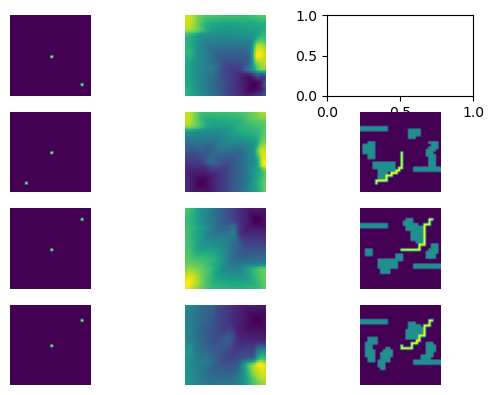

In [31]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 3)
num_steps = 1024
directions = [[-1, 0], [1, 0], [0, -1], [0, 1]]
history = torch.zeros_like(map_designs)
collected = torch.zeros_like(map_designs, dtype=torch.bool)

for i in range(start_maps.shape[0]):
    map_design = 1 - map_designs[i, 0]
    current_loc = torch.nonzero(start_maps[i, 0]).squeeze().tolist()
    goal_loc = torch.nonzero(goal_maps[i, 0]).squeeze().tolist()
    collected[i, 0][current_loc[0], current_loc[1]] = True
    axes[i, 0].imshow((start_maps + goal_maps)[i, 0])
    axes[i, 0].axis("off")
    print(goal_loc)
    history[i, 0][current_loc[0], current_loc[1]] = 1
    outputs = -model(torch.cat((map_designs, goal_maps), dim=1))[i, 0]
    axes[i, 1].imshow(outputs.detach().cpu().numpy())
    axes[i, 1].axis("off")
    for t in range(num_steps):
        min_dist = 1024
        next_loc = None
        for j in range(4):
            next_x = current_loc[0] + directions[j][0]
            next_y = current_loc[1] + directions[j][1]
            if next_x > 31 or next_x < 0 or next_y > 31 or next_y < 0:
                continue
            if collected[i, 0][next_x, next_y].item() is True or map_design[next_x, next_y].item() == 1:
                continue
            if outputs[next_x][next_y] < min_dist:
                min_dist = outputs[next_x][next_y]
                next_loc = [next_x, next_y]
        
        if next_loc is None:
            print("找不到了")
            break
        current_loc = next_loc
        collected[i, 0][current_loc[0], current_loc[1]] = True
        history[i, 0][current_loc[0], current_loc[1]] = 1
        if current_loc == goal_loc:
            map_design = map_design * 0.5
            axes[i, 2].imshow(history[i, 0] + map_design)
            axes[i, 2].axis("off")
            break

tensor([[50.6513, 45.1345, 43.1021,  ..., 38.1989, 39.3812, 43.2263],
        [47.1356, 41.5769, 40.8438,  ..., 36.2606, 36.6607, 41.1124],
        [44.8985, 41.6848, 40.1832,  ..., 35.8397, 36.1946, 40.4071],
        ...,
        [17.5238, 12.0215, 10.7677,  ..., 29.9954, 29.9556, 32.5358],
        [18.9933, 14.9371, 13.8227,  ..., 31.1587, 31.2219, 34.8202],
        [22.1362, 20.0053, 18.9170,  ..., 33.4859, 34.9477, 37.7720]],
       grad_fn=<NegBackward0>)


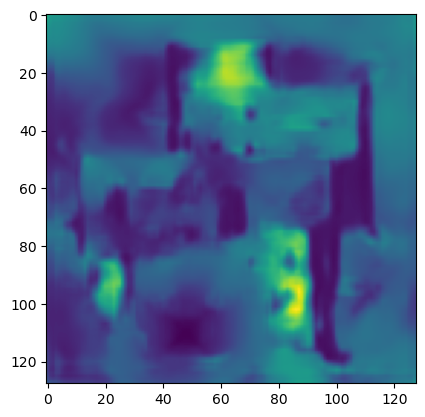

In [41]:
from PIL import Image
import numpy as np

tmp = np.array(Image.open(r"C:\Users\guangqian.chen\Desktop\sulaman.jpg"))
image = np.zeros_like(tmp)
image[tmp >= 128] = 1
image = np.expand_dims(image, axis=(0, 1))
image = torch.from_numpy(image).float()
goal_map = torch.zeros_like(image).float()
goal_map[0, 0, 110, 48] = 1

ccc = model(torch.cat((image, goal_map), dim=1))
plt.imshow(-ccc[0, 0].detach())
print(-ccc[0, 0])
